<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/ROIs_J%C3%BClich_atlas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Jülich atlas is a cytoarchitectonic probabilistic atlas, derived from post-mortem histology and warped into MNI space. It includes much finer subdivisions than Harvard–Oxford (which only has “hippocampus” as a whole), e.g., subiculum, dentate gyrus (DG), cornu ammonis (CA1-3).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install nilearn
from nilearn import datasets, plotting, image, masking
import numpy as np
import os

In [4]:
# Load the MNI template brain for visualisation
mni = datasets.load_mni152_template()

# Jülich Atlas

# Inspect the Jülich Atlas Docs.

In [5]:
# Inspect the doc. for the Jülich atlas
from nilearn.datasets import fetch_atlas_juelich
print(fetch_atlas_juelich.__doc__)

Load Juelich parcellations from FSL.

    This function downloads Juelich atlas packaged from FSL 5.0
    and stores atlases in NILEARN_DATA folder in home directory.

    This function can also load Juelich atlas from your local directory
    specified by your FSL installed path given in `data_dir` argument.
    See documentation for details.

    .. versionadded:: 0.8.1

    .. note::

        For atlases 'prob-1mm', and 'prob-2mm', the function returns a
        :term:`Probabilistic atlas`, and the
        :class:`~nibabel.nifti1.Nifti1Image` returned is 4D, with shape
        ``(182, 218, 182, 62)``.
        For :term:`deterministic atlases<Deterministic atlas>`, the
        :class:`~nibabel.nifti1.Nifti1Image` returned is 3D, with shape
        ``(182, 218, 182)`` and 62 regions (+ background).

    Parameters
    ----------
    atlas_name : :obj:`str`
        Name of atlas to load. Can be:
        "maxprob-thr0-1mm", "maxprob-thr0-2mm",
        "maxprob-thr25-1mm", "maxprob-thr25

In [6]:
# Fetch probabilistic Jülich atlas (1 mm)
julich = datasets.fetch_atlas_juelich("prob-1mm")  # or "maxprob-thr50-1mm"
labels = julich.labels

print("Number of labels:", len(labels))

[fetch_atlas_juelich] Added README.md to /root/nilearn_data

[fetch_atlas_juelich] Dataset created in /root/nilearn_data/fsl

[fetch_atlas_juelich] Downloading data from https://www.nitrc.org/frs/download.php/12096/Juelich.tgz ...

[fetch_atlas_juelich]  ...done. (0 seconds, 0 min)

[fetch_atlas_juelich] Extracting data from /root/nilearn_data/fsl/5f0f3de71552237df29d0de14db5f8c8/Juelich.tgz...

[fetch_atlas_juelich] .. done.

Number of labels: 63


In [7]:
labels

[np.str_('Background'),
 np.str_('GM Amygdala_centromedial group'),
 np.str_('GM Amygdala_laterobasal group'),
 np.str_('GM Amygdala_superficial group'),
 np.str_('GM Anterior intra-parietal sulcus hIP1'),
 np.str_('GM Anterior intra-parietal sulcus hIP2'),
 np.str_('GM Anterior intra-parietal sulcus hIP3'),
 np.str_("GM Broca's area BA44"),
 np.str_("GM Broca's area BA45"),
 np.str_('GM Hippocampus cornu ammonis'),
 np.str_('GM Hippocampus dentate gyrus'),
 np.str_('GM Hippocampus entorhinal cortex'),
 np.str_('GM Hippocampus hippocampal-amygdaloid transition area'),
 np.str_('GM Hippocampus subiculum'),
 np.str_('GM Inferior parietal lobule PF'),
 np.str_('GM Inferior parietal lobule PFcm'),
 np.str_('GM Inferior parietal lobule PFm'),
 np.str_('GM Inferior parietal lobule PFop'),
 np.str_('GM Inferior parietal lobule PFt'),
 np.str_('GM Inferior parietal lobule PGp'),
 np.str_('GM Inferior parietal lobule Pga'),
 np.str_('GM Insula Id1'),
 np.str_('GM Insula Ig1'),
 np.str_('GM Insu

In [ ]:
# Fetch probabilistic Jülich atlas (1 mm)
julich = datasets.fetch_atlas_juelich("maxprob-thr50-1mm")  # or "prob-1mm"
labels = julich.labels

print("Number of labels:", len(labels))
for i, lab in enumerate(labels):
    if "Hippocampus" in lab or "CA" in lab or "Subiculum" in lab or "Dentate" in lab:
        print(i, lab)

[fetch_atlas_juelich] Dataset found in /root/nilearn_data/fsl

Number of labels: 63
9 GM Hippocampus cornu ammonis
10 GM Hippocampus dentate gyrus
11 GM Hippocampus entorhinal cortex
12 GM Hippocampus hippocampal-amygdaloid transition area
13 GM Hippocampus subiculum


/tmp/ipython-input-2490168894.py:2: UserWarning: 
The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index                                                  name
    12 GM Hippocampus hippocampal-amygdaloid transition area

  julich = datasets.fetch_atlas_juelich("maxprob-thr50-1mm")  # or "prob-1mm"


# Probabilistic Jülich Atlas

`"prob-1mm"`

In [ ]:
# Load Jülich probabilistic atlas
julich_prob = datasets.fetch_atlas_juelich("prob-1mm")
atlas_img = julich_prob.maps
labels = julich_prob.labels

[fetch_atlas_juelich] Dataset found in /root/nilearn_data/fsl

In [ ]:
# Helper function since without the background all indices are idx-1

def get_julich_roi(atlas_img, labels, query):
    """
    Retrieve a probabilistic ROI map from the Jülich atlas.

    Parameters
    ----------
    atlas_img : Nifti1Image
        The 4D probabilistic atlas (from fetch_atlas_juelich("prob-1mm")).
    labels : list of str
        Label names (includes "Background" at index 0).
    query : str
        Case-insensitive string to match (e.g. "subiculum").

    Returns
    -------
    roi_img : Nifti1Image
        The 3D probabilistic ROI image (values 0–100).
    idx : int
        The correct index in the 4D atlas (after Background correction).
    label : str
        The matched label string.
    """
    # Find label index (includes Background as [0])
    matches = [i for i, lab in enumerate(labels) if query.lower() in lab.lower()]
    if not matches:
        raise ValueError(f"No ROI found for query '{query}'.")

    # First match (you could extend this for multiple)
    label_idx = matches[0]
    map_idx = label_idx - 1  # Correct for Background
    if map_idx < 0:
        raise ValueError("Background is not a valid ROI.")

    roi_img = image.index_img(atlas_img, map_idx)
    return roi_img, map_idx, labels[label_idx]


In [ ]:
# Function to split the ROI along the midline, which is x=0 in MNI space
# Other than in the HO atlas, the Jülich atlas does not automatically seperate the ROIs in LH and RH

def split_left_right(mask_img):
    """Split a bilateral ROI into left/right hemisphere masks."""
    data = mask_img.get_fdata()
    affine = mask_img.affine

    # Find voxel index corresponding to x=0
    x_voxel = int(round(np.linalg.inv(affine).dot([0, 0, 0, 1])[0]))

    left_data = np.zeros_like(data)
    right_data = np.zeros_like(data)

    left_data[:x_voxel, :, :] = data[:x_voxel, :, :]
    right_data[x_voxel:, :, :] = data[x_voxel:, :, :]

    left_img = image.new_img_like(mask_img, left_data, affine)
    right_img = image.new_img_like(mask_img, right_data, affine)
    return left_img, right_img


## Subiculum

In [ ]:
# Get subiculum (bilateral)
subiculum_img, idx, label = get_julich_roi(atlas_img, labels, "subiculum")

In [ ]:
# Split into hemispheres
sub_left, sub_right = split_left_right(subiculum_img)

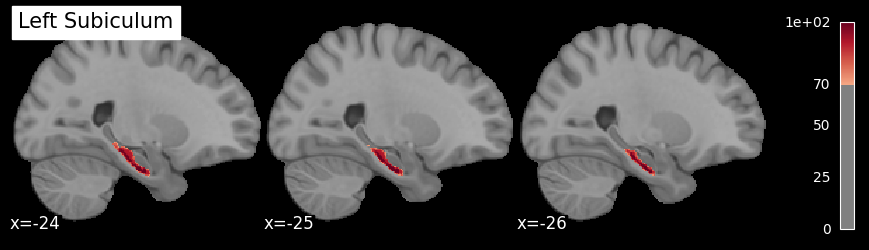

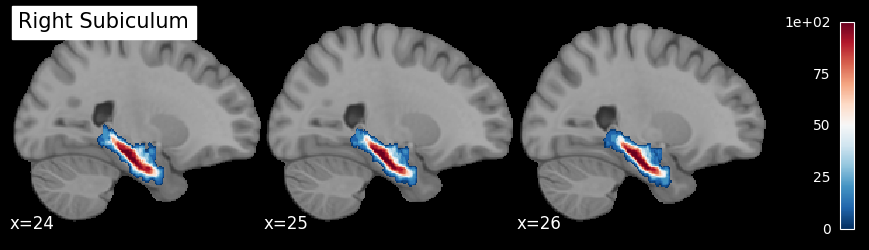

In [ ]:
# Plot the subiculum in LH and RH

plotting.plot_stat_map(sub_left, bg_img=datasets.load_mni152_template(),
                       title="Left Subiculum", display_mode="x", cut_coords=[-24,-25,-26],
                       threshold=70, vmax=100, draw_cross=False)

plotting.plot_stat_map(sub_right, bg_img=datasets.load_mni152_template(),
                       title="Right Subiculum", display_mode="x", cut_coords=[24,25,26],
                       threshold=0, vmax=100, draw_cross=False)

plotting.show()

## Dentate Gyrus (DG)

In [ ]:
# Get dentate gyrus (bilateral)
dg_img, idx, label = get_julich_roi(atlas_img, labels, "dentate gyrus")


In [ ]:
# Split into hemispheres
dg_left, dg_right = split_left_right(dg_img)

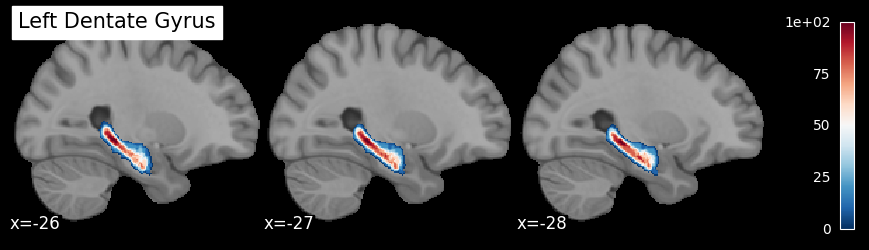

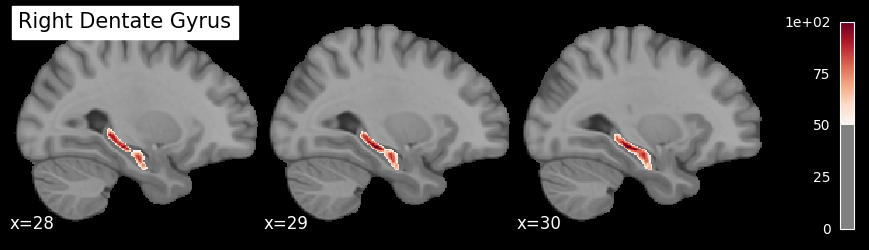

In [ ]:
# Plot the dentate gyrus in LH and RH

plotting.plot_stat_map(dg_left, bg_img=datasets.load_mni152_template(),
                       title="Left Dentate Gyrus", display_mode="x", cut_coords=[-26,-27,-28],
                       threshold=0, vmax=100, draw_cross=False)

plotting.plot_stat_map(dg_right, bg_img=datasets.load_mni152_template(),
                       title="Right Dentate Gyrus", display_mode="x", cut_coords=[28,29,30],
                       threshold=50, vmax=100, draw_cross=False)

plotting.show()

## Cornu Ammonis (CA)

In [ ]:
# Get cornu ammonis (bilateral)
ca_img, idx, label = get_julich_roi(atlas_img, labels, "cornu ammonis")

In [ ]:
# Split into hemispheres
ca_left, ca_right = split_left_right(ca_img)

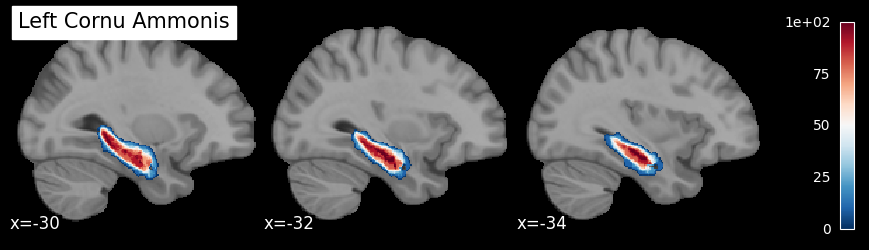

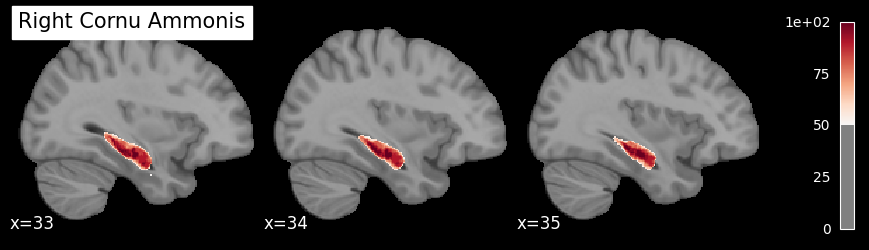

In [ ]:
# Plot the cornu ammonis in LH and RH

plotting.plot_stat_map(ca_left, bg_img=datasets.load_mni152_template(),
                       title="Left Cornu Ammonis", display_mode="x", cut_coords=[-30,-32,-34],
                       threshold=0, vmax=100, draw_cross=False)

plotting.plot_stat_map(ca_right, bg_img=datasets.load_mni152_template(),
                       title="Right Cornu Ammonis", display_mode="x", cut_coords=[33,34,35],
                       threshold=50, vmax=100, draw_cross=False)

plotting.show()

# Deterministic (Maxprob.) Jülich Atlas

`"maxprob-thr50-1mm"`

In [ ]:
# Load deterministic atlas (50% threshold)
julich_det = datasets.fetch_atlas_juelich("maxprob-thr50-1mm")
atlas_det = julich_det.maps      # 3D segmentation map
labels_det = julich_det.labels   # includes "Background" at [0]

[fetch_atlas_juelich] Dataset found in /root/nilearn_data/fsl

/tmp/ipython-input-208421315.py:2: UserWarning: 
The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index                                                  name
    12 GM Hippocampus hippocampal-amygdaloid transition area

  julich_det = datasets.fetch_atlas_juelich("maxprob-thr50-1mm")


Importantly, I can re-use the function to split the ROIs (subiculum, dentate gyrus or cornu ammonis) into the hemispheres.

In [ ]:
def get_julich_det_roi(atlas_img, labels, query):
    """Extract a binary mask from Jülich maxprob atlas."""
    matches = [i for i, lab in enumerate(labels) if query.lower() in lab.lower()]
    if not matches:
        raise ValueError(f"No ROI found for query '{query}'")
    idx = matches[0]
    roi_img = image.math_img(f"img == {idx}", img=atlas_img)
    return roi_img, idx, labels[idx]

## Subiculum

In [ ]:
# Get the subiculum (bilateral) from maxprob-thr50-1mm
sub_det, sub_idx, sub_label = get_julich_det_roi(atlas_det, labels_det, "subiculum")

In [ ]:
# Split into hemispheres
sub_left, sub_right = split_left_right(sub_det) # Apply the split function

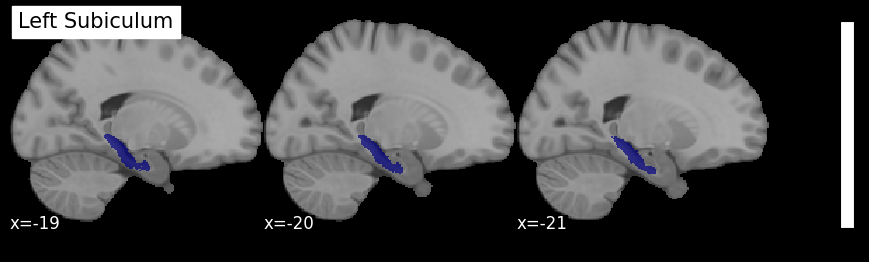

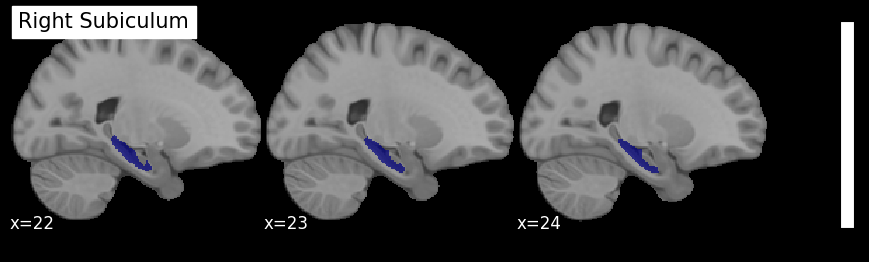

In [ ]:
# Plot the subiculum in LH and RH

plotting.plot_roi(sub_left, bg_img=mni,
                  title="Left Subiculum",
                  display_mode="x", cut_coords=[-19,-20,-21], draw_cross=False)

plotting.plot_roi(sub_right, bg_img=mni,
                  title="Right Subiculum",
                  display_mode="x", cut_coords=[22,23,24], draw_cross=False)

plotting.show()


## Dentate Gyrus (DG)

In [ ]:
# Get the dentate gyrus (bilateral)
dg_det, dg_idx, dg_label = get_julich_det_roi(atlas_det, labels_det, "dentate gyrus")

In [ ]:
# Split into hemispheres
dg_left, dg_right = split_left_right(dg_det)

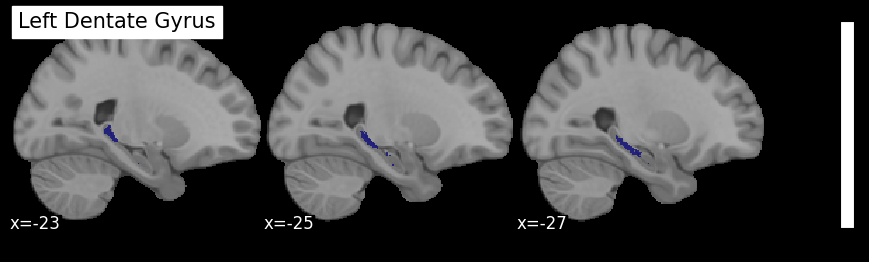

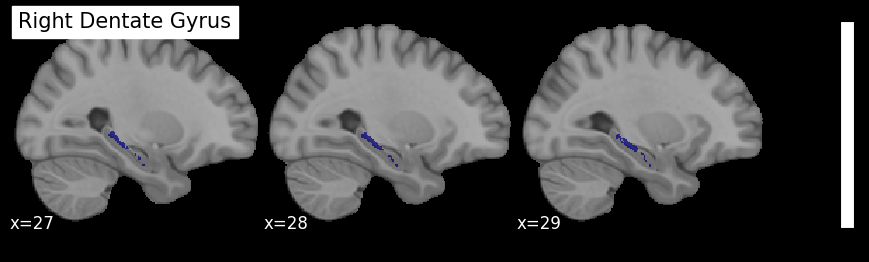

In [ ]:
# Plot the dentate gyrus in LH and RH

plotting.plot_roi(dg_left, bg_img=mni,
                  title="Left Dentate Gyrus",
                  display_mode="x", cut_coords=[-23,-25,-27], draw_cross=False)

plotting.plot_roi(dg_right, bg_img=mni,
                  title="Right Dentate Gyrus",
                  display_mode="x", cut_coords=[27,28,29], draw_cross=False)

plotting.show()

## Cornu Ammonis (CA)

In [ ]:
# Get the cornu ammonis (bilateral)
ca_det, ca_idx, ca_label = get_julich_det_roi(atlas_det, labels_det, "cornu ammonis")

In [ ]:
# Split into hemispheres
ca_left, ca_right = split_left_right(ca_det)

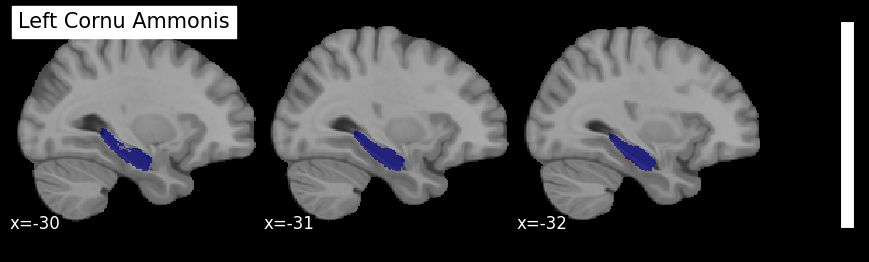

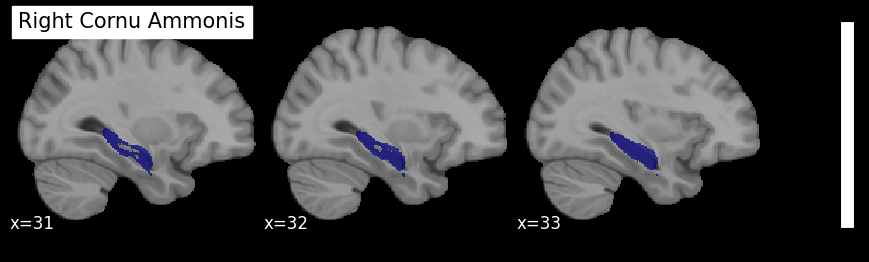

In [ ]:
# Plot the cornu ammonis in LH and RH

plotting.plot_roi(ca_left, bg_img=mni,
                  title="Left Cornu Ammonis",
                  display_mode="x", cut_coords=[-30,-31,-32], draw_cross=False)

plotting.plot_roi(ca_right, bg_img=mni,
                  title="Right Cornu Ammonis",
                  display_mode="x", cut_coords=[31,32,33], draw_cross=False)

plotting.show()

# Define the Hippocampus ROI

I believe it makes most sense to create seperate masks for subiculum, DG and CA for both LH and RH, meaning that I get 6 different masks in the end for the voxel reliability. Depending on the voxel reliability results, I could then combine those masks and split them according to the y-coordinate of -21 (Poppenk et al., 2013). Other than the approach that I used in the Harvard-Oxford atlas, I would decide on the final ROI masks AFTER the voxel reliability results.

# Save the ROI masks

Important! These are the ROI masks PRE voxel reliability for the Jülich atlas. The final hippocampus masks for the Jülich atlas will be created AFTER the voxel reliability analysis!!

# Try-out HO atlas

In [ ]:
# Inspect the doc. for the Harvard-Oxford atlas
from nilearn.datasets import fetch_atlas_harvard_oxford

In [ ]:
# Load atlas
ho_prob = datasets.fetch_atlas_harvard_oxford("sub-prob-1mm")

# Extract Left and Right Hippocampus
left_hipp = image.index_img(ho_prob.maps, 9)   #see cell above for the indices
right_hipp = image.index_img(ho_prob.maps, 19)

[fetch_atlas_harvard_oxford] Dataset found in /root/nilearn_data/fsl

In [ ]:
# Extract Left and Right Hippocampus
left_hipp = image.index_img(ho_prob.maps, 8)   #see cell above for the indices
right_hipp = image.index_img(ho_prob.maps, 18)

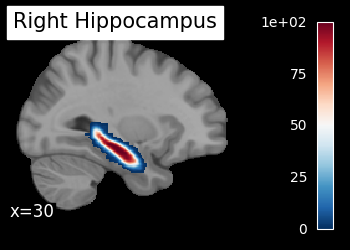

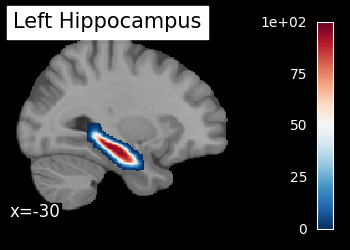

In [ ]:
# Example: plot right hippocampus at different x positions
plotting.plot_stat_map(
    right_hipp, bg_img=mni,
    title="Right Hippocampus",
    display_mode="x", cut_coords=[30], threshold=0, vmax=100
)

# Example: plot left hippocampus at different x positions
plotting.plot_stat_map(
    left_hipp, bg_img=mni,
    title="Left Hippocampus", # For LH the coordinate is negative (-)!!
    display_mode="x", cut_coords=[-30], threshold=0, vmax=100
)